In [ ]:
import numpy as np
import math
import torch
from PIL import Image
from torchvision import datasets, transforms
from torch.nn.utils import weight_norm
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F
import copy
import numpy as np
import torchvision.utils as vutils
import time
import matplotlib.pyplot as plt   
import torchvision.utils as vutils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/601.682/Final_PJ/semi-inat-2021.zip /
!unzip -qq /semi-inat-2021.zip 

In [ ]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import random
l_train_path = './l_train'
u_train_path = './u_train'
val_path = './val'
test_path = './test'
classes = 810
max_width = 300
max_length = 300

input_size = 224

## Image Transforms

##following are required 
# this one is to convert to pytorch format 
to_pytorch_tensor = transforms.Compose([
        transforms.PILToTensor(),
        
])

# some images are not 3 channels
to_3channels = transforms.Compose([
        transforms.Lambda(lambda x: x.repeat(3,1,1))
        ])
    
#for l_train and val
#there are 810 folders from 0 to 809
#will return image and label
#if use the default transfrom, image will be a pytorch tensor
#pass use_memory = False, if ran out of ram
class iNat_dataset_labeled(Dataset):
    def __init__(self, 
                 data_type, 
                 tf = None):
      self.data_type = data_type
      if self.data_type == 'l_train':
        self.data_dir = os.path.join(l_train_path, 'l_train')
      elif self.data_type == 'val':
        self.data_dir = os.path.join(val_path, 'val')
      #if load all data into memeory
      self.transform = tf
      self.data = []
      self.labels = []
      for i in range(classes):
        path = os.path.join(self.data_dir, str(i))
        images = os.listdir(path)
        for j in range(len(images)):
          img = os.path.join(path, images[j])
          img = Image.open(img)
          self.data.append(img)
          self.labels.append(i)

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, idx):
      img = self.data[idx]
      img = to_pytorch_tensor(img)
      if img.size(0) != 3:
        img = to_3channels(img)
      if self.transform:
        img = self.transform(img)
      
      return img, self.labels[idx]

#for u_train and test
#return image and its file name 
class iNat_dataset_unlabeled(Dataset):
    def __init__(self, 
                 data_type, 
                 tf = None):
      self.data_type = data_type
      if self.data_type == 'u_train':
        self.data_dir = os.path.join(u_train_path, 'u_train')
      elif self.data_type == 'test':
        self.data_dir = os.path.join(test_path, 'test')

      self.transform = tf
      self.data = []
      self.names = []

      images = os.listdir(self.data_dir)
      for i in range(len(images)):
        path = os.path.join(self.data_dir, images[i])
        self.data.append(path)
        self.names.append(images[i])

    def __len__(self):
      return len(self.names)

    def __getitem__(self, idx):
      img = Image.open(self.data[idx])
      img = to_pytorch_tensor(img)

      if img.size(0) != 3:
        if img.size(0) == 1:
          img = to_3channels(img)
        else:
          idx = 0
          path = os.path.join(u_train_path, 'u_train', self.names[idx])
          img = Image.open(path)
          img = to_pytorch_tensor(img)

      if self.transform:
        img = self.transform(img)
      
      return img

In [ ]:
mean,std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

weak_img_augmentation = transforms.Compose([                                            
        transforms.RandomHorizontalFlip(0.5),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean,std),
])
strong_img_augmentation = transforms.Compose([
        transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean,std),
])
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean,std)
])
test_transform = transforms.Compose([
        transforms.Resize([input_size,input_size]),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean,std)
])

u_preprocess = transforms.Compose([                         
        transforms.RandomResizedCrop(input_size)])

In [ ]:
l_train_batch_size = 8
val_batch_size = 8
u_train_batch_size = 8
batch_size = 8

In [ ]:
l_train_dataset=iNat_dataset_labeled(data_type="l_train", tf=train_transform)
val_dataset=iNat_dataset_labeled(data_type="val", tf=test_transform)
test_dataset=iNat_dataset_unlabeled(data_type="test", tf=test_transform)
u_train_dataset=iNat_dataset_unlabeled(data_type="u_train", tf=train_transform)

In [ ]:
#l_train_dataset=iNat_dataset_labeled(data_type="l_train", tf=img_transform)
l_train_dataloader = DataLoader(l_train_dataset, batch_size=l_train_batch_size, shuffle=True)

#val_dataset=iNat_dataset_labeled(data_type="val", tf=img_transform)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

#u_train_dataset=iNat_dataset_unlabeled(data_type="u_train", tf=img_transform)
u_train_dataloader = DataLoader(u_train_dataset, batch_size=u_train_batch_size, shuffle=True)

#test_dataset=iNat_dataset_unlabeled(data_type="test", tf=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
nz = 100
nc = 3
lr_gen = lr_cla = lr = 0.0003
num_epochs = 100
train_interval_gen = 1
train_interval_dis = 1
clamp_max = 0.01
ngf = 64 # num of feature maps in generator
ndf = 32 # num of feature maps in generator
fm_layer = 'net' #for Resnet feature_matching layer: 'layer1','layer2','layer3','layer4','avgpool','fc'
mul = 1 #scale loss on labelled data to match with wasserstein loss
Feature_match = True #whether to use feature matching
label_smooth = 1

In [ ]:

class Discriminator(nn.Module):
        def __init__(self,num_classes):
            super(Discriminator, self).__init__()
            self.net = nn.Sequential(
                    nn.Dropout(.2),
                    weight_norm(nn.Conv2d(3,ndf * 3,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(ndf * 3,ndf * 3,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(ndf * 3,ndf * 3,3,stride=2,padding=1)),
                    nn.LeakyReLU(),
                    #112
                    nn.Dropout(.5),
                    weight_norm(nn.Conv2d(ndf * 3,ndf * 6,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(ndf * 6,ndf * 6,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(ndf * 6,ndf * 6,3,stride=2,padding=1)),
                    nn.LeakyReLU(),
                    #56
                    nn.Dropout(.5),
                    weight_norm(nn.Conv2d(ndf * 6,ndf * 6,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(ndf * 6,ndf * 6,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(ndf * 6,ndf * 6,3,stride=2,padding=1)),
                    nn.LeakyReLU(),
                    #28
                    nn.Dropout(.5),
                    weight_norm(nn.Conv2d(ndf * 6,ndf * 6,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(ndf * 6,ndf * 6,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(ndf * 6,ndf * 6,3,stride=2,padding=1)),
                    nn.LeakyReLU(),
                    #14
                    nn.Dropout(.5),
                    weight_norm(nn.Conv2d(ndf * 6,ndf * 6,3,stride=1,padding=0)), #12
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(ndf * 6,ndf * 6,1,stride=1,padding=0)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(ndf * 6,ndf * 6,1,stride=1,padding=0)),
                    nn.LeakyReLU(),

                    # nn.AvgPool2d(6,stride=1),
                    nn.AdaptiveAvgPool2d(1),
                    nn.Flatten()
                )

            self.fc = weight_norm(nn.Linear(ndf * 6,num_classes))
            
        def forward(self,x):
            inter_layer = self.net(x)
            logits = self.fc(inter_layer)
            return inter_layer, logits

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d( ngf*16, ngf * 16, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 7 x 7
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 14 x 14
            nn.ConvTranspose2d( ngf * 8, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 28 x 28
            nn.ConvTranspose2d( ngf * 8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state size. (ngf*4) x 56 x 56
            nn.ConvTranspose2d( ngf * 4, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 112 x 112
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 224 x 244
        )
        self.enlargenoise = nn.Sequential(
            nn.Linear(nz, ngf * 16 * 4 * 4),
            nn.BatchNorm1d(ngf * 16 * 4 * 4),
            nn.ReLU(),
        )

    def forward(self, input):
        x = self.enlargenoise(input.squeeze())
        x = x.view((-1,ngf*16,4,4))
        return self.main(x)

In [ ]:
def init_normal(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight,mean=.0,std=.05)
            nn.init.constant_(m.bias,.0)

        if type(m) == nn.ConvTranspose2d:
            nn.init.normal_(m.weight,mean=0,std=.05)


In [ ]:
class FeatureExtractor(nn.Module):

    def __init__(self, submodule, extracted_layers):

        super(FeatureExtractor, self).__init__()

        self.submodule = submodule.cuda()

        self.extracted_layers = extracted_layers

    def forward(self, x):
        out_dict={}
        for name, module in self.submodule._modules.items():

            if name is "fc": x = x.view(x.size(0), -1)

            x = module(x)

            if name in self.extracted_layers:

                out_dict[name]=x
        return out_dict

In [ ]:
def test(model, test_loader, m_test, display = False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for label_image, label in test_loader:
            label_image,label = label_image.cuda(),label.cuda()
            _,output = model(label_image)
            test_loss += criterion_C(output, label).item() 
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    if display == True:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, m_test,
        100. * correct / m_test))
           
    return test_loss, 100. * correct / m_test/len(test_loader)


In [ ]:
def wasserstein_loss(y_true, y_pred):
    return torch.mean(y_true * y_pred)
def log_sum_exp(x, axis = 1):
    m = torch.max(x, dim = 1)[0]    
    return m + torch.log(torch.sum(torch.exp(x- m.unsqueeze(1)), dim = axis)) 

In [ ]:
netG = Generator().apply(init_normal).cuda()
netDC = Discriminator(classes).apply(init_normal).cuda()

In [ ]:
optimizer_G  = torch.optim.RMSprop(netG.parameters(), lr=lr)
optimizer_DC  = torch.optim.RMSprop(netDC.parameters(), lr=lr)
scheduler_G = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, mode='min', factor=0.5, patience=30, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
scheduler_DC = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_DC, mode='min', factor=0.5, patience=30, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

criterion_C = nn.CrossEntropyLoss().cuda()
criterion_G = nn.MSELoss().cuda()

fixed_noise = torch.randn(batch_size,nz).cuda()


G_losses = []
DC_losses = []

best_model_wts = copy.deepcopy(netDC.state_dict())
best_acc = 0.0


Test set: Average loss: 5.9268, Accuracy: 328/9721 (3%)


Test set: Average loss: 6.7079, Accuracy: 36/4050 (1%)

ETA of completion: 35967.33916004499 minutes: curr_epoch 0


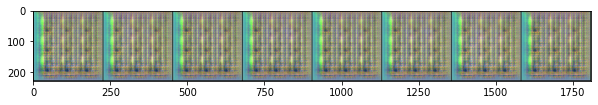

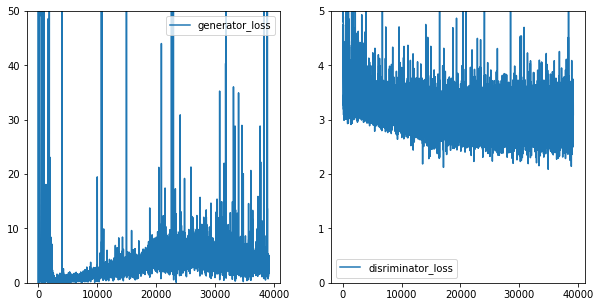


Test set: Average loss: 5.5840, Accuracy: 579/9721 (6%)


Test set: Average loss: 6.9046, Accuracy: 66/4050 (2%)

ETA of completion: 35528.86459457874 minutes: curr_epoch 1


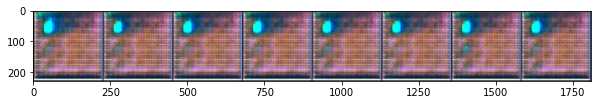

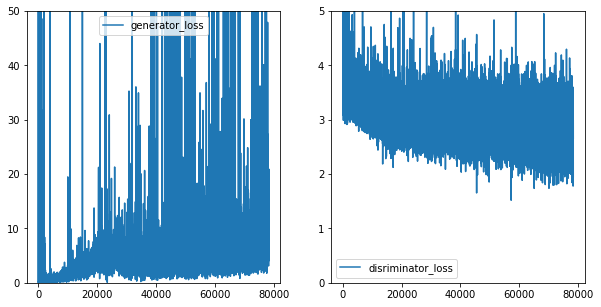


Test set: Average loss: 5.2851, Accuracy: 797/9721 (8%)


Test set: Average loss: 6.7639, Accuracy: 90/4050 (2%)

ETA of completion: 35004.588017725946 minutes: curr_epoch 2


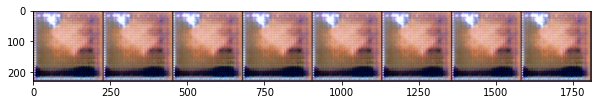

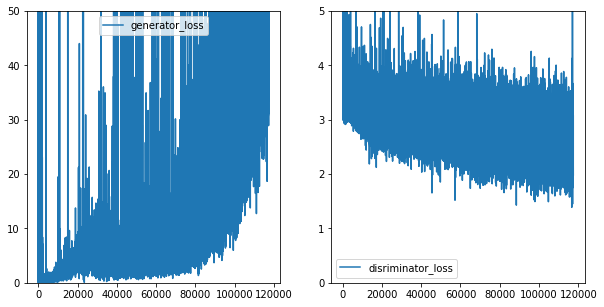

In [ ]:
for epoch in range(num_epochs):
    time1 = time.time()

    for u_data in u_train_dataloader:

        l_data, label = next(iter(l_train_dataloader))
        u_data = u_data.cuda()
        l_data = l_data.cuda()
        label = label.cuda()
        noise = torch.randn(u_data.size(0), nz).cuda() #label or unlabel

        netDC.train()
        optimizer_DC.zero_grad()

        _,l_logit = netDC(l_data)
        _,u_logit = netDC(u_data)
        generated = netG(noise)
        _,fake_logit = netDC(generated.detach())

        loss_D = 0.5*wasserstein_loss(log_sum_exp(u_logit)-F.softplus(log_sum_exp(u_logit)),-1)+0.5*wasserstein_loss(F.softplus(log_sum_exp(fake_logit) ), 1)
        loss_C = criterion_C(l_logit, label)
        loss_DC = 0.5*loss_D + 0.5*loss_C
        loss_DC.backward()
        optimizer_DC.step()
        DC_losses.append(loss_DC.item())


        optimizer_DC.zero_grad()
        optimizer_G.zero_grad()
        generated = netG(noise)
        feature_fake,_ = netDC(generated)
        feature_real,_ = netDC(u_data)

        loss_G = criterion_G(torch.mean(feature_fake,dim=0) ,torch.mean(feature_real,dim=0))
        loss_G.backward()
        optimizer_G.step()
        G_losses.append(loss_G.item())
    
    
    with torch.no_grad():
        netDC.eval()
        test(netDC, l_train_dataloader, len(l_train_dataset), True)
        val_loss, val_accuracy = test(netDC, val_dataloader, len(val_dataset), True)
    scheduler_DC.step(val_loss)
    scheduler_G.step(val_loss)

    if val_accuracy > best_acc:
        best_acc = val_accuracy
        best_classifier_wts = copy.deepcopy(netDC.state_dict())
        best_generator_wts = copy.deepcopy(netG.state_dict())
        torch.save(best_generator_wts, '/content/drive/MyDrive/601.682/Final_PJ/netG_bestinat.pth')
        torch.save(best_classifier_wts, '/content/drive/MyDrive/601.682/Final_PJ/netDC_bestinat.pth')



    time2 = time.time()
    print('ETA of completion:',(time2 - time1)*(num_epochs - epoch)/60,'minutes: curr_epoch',epoch)
    fig = plt.figure(figsize=(10,5))
    generated = (netG(fixed_noise)+1.0)/2.0
    grid=vutils.make_grid(generated[0:16].cpu().detach())
    plt.imshow(np.transpose(grid,(1,2,0)))
    plt.show()
    fig = plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.plot(range(0,len(G_losses*train_interval_gen),train_interval_gen), np.array(G_losses),label='generator_loss')
    plt.ylim(0,50)
    plt.legend()
    plt.subplot(122)
    plt.plot(range(0,len(DC_losses*train_interval_dis),train_interval_dis), np.array(DC_losses),label='disriminator_loss')
    plt.ylim(0,5)
    plt.legend()
    plt.show()